In [142]:
import datetime
import time as time_module
import sys
import os 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import theano
import matplotlib
import pymc3 as pm
import theano.tensor as tt

try: 
    import covid19_inference as cov19
except ModuleNotFoundError:
    sys.path.append('..')
    import covid19_inference as cov19



In [14]:
df_rki = cov19.data_retrieval.get_rki()

In [37]:
df_bundeslaender = cov19.filter_rki_all_bundesland(df_rki, '2020-03-10', '2020-04-13')
new_cases_obs = np.diff(np.array(df_bundeslaender),axis=0)[:,:]


date_begin_data = datetime.datetime(2020,3,10)
date_end_data   = datetime.datetime(2020,3,13)
diff_data_sim = 16 # should be significantly larger than the expected delay, in 
                   # order to always fit the same number of data points.
num_days_forecast = 10

prior_date_mild_dist_begin =  datetime.datetime(2020,3,9)
prior_date_strong_dist_begin =  datetime.datetime(2020,3,16)
prior_date_contact_ban_begin =  datetime.datetime(2020,3,23)

change_points = [dict(pr_mean_date_transient = prior_date_mild_dist_begin,
                      pr_sigma_date_transient = 6,
                      pr_median_lambda = 0.2,
                      pr_sigma_lambda = 1),
                 dict(pr_mean_date_transient = prior_date_strong_dist_begin,
                      pr_sigma_date_transient = 6,
                      pr_median_lambda = 1/8,
                      pr_sigma_lambda = 1),
                 dict(pr_mean_date_transient = prior_date_contact_ban_begin,
                      pr_sigma_date_transient = 6,
                      pr_median_lambda = 1/8/2,
                      pr_sigma_lambda = 1)]

In [55]:
params_model = dict(new_cases_obs = new_cases_obs[:,0],
                    date_begin_data = date_begin_data,
                    num_days_forecast = num_days_forecast,
                    diff_data_sim = diff_data_sim,
                    N_population = 83e6) 
# normally one would put as N_population an array with the number of inhabitants of 
# of each state

with cov19.Cov19_Model(**params_model) as model:
    lambda_t_log = cov19.lambda_t_with_sigmoids(pr_median_lambda_0 = 0.4,
                                                change_points_list = change_points)
    
    new_I_t = cov19.SIR(lambda_t_log, pr_median_mu=1/8)
    
    new_cases_inferred_raw = cov19.delay_cases(new_I_t, pr_median_delay=10, 
                                               pr_median_scale_delay=0.3)
    
    new_cases_inferred = cov19.week_modulation(new_cases_inferred_raw)
    
    cov19.student_t_likelihood(new_cases_inferred)


In [ ]:
trace = pm.sample(model=model, tune=500, draws=500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /home/jdehning/.theano/compiledir_Linux-4.18--generic-x86_64-with-debian-buster-sid-x86_64-3.7.6-64/lock_dir/lock
Multiprocess sampling (6 chains in 6 jobs)
NUTS: [sigma_obs, delay_L2_raw, delay_L1, sigma_delay_L2, I_begin, mu, transient_len_3_L2_raw, transient_len_3_L1, sigma_transient_len_3_L2, transient_len_2_L2_raw, transient_len_2_L1, sigma_transient_len_2_L2, transient_len_1_L2_raw, transient_len_1_L1, sigma_transient_len_1_L2, transient_day_3_L2_raw, transient_day_3_L1, sigma_transient_day_3_L2, transient_day_2_L2_raw, transient_day_2_L1, sigma_transient_day_2_L2, transient_day_1_L2_raw, transient_day_1_L1, sigma_transient_day_1_L2, lambda_3_L2_raw, lambda_3_L1, sigma_lambda_3_L2, lambda_2_L2_raw, lambda_2_L1, sigma_lambda_2_L2, lambda_1_L2_raw, lambda_1_L1, sigma_lambda_1_L2, lambda_0_L2_raw, lambda_0_L1, sigma_lambda_0_L2]
Sampling 6 chains, 0 divergences:

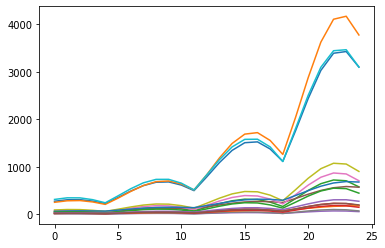

In [35]:
plt.plot(np.median(trace.new_cases, axis=0))